# **Importer les Bibliothèques et Initialiser Spark**

In [1]:
import sys
from pyspark.sql import SparkSession
import matplotlib.pyplot as plt
from pyspark.sql import functions as F

In [2]:
spark = SparkSession.builder \
    .appName("Data Processing dans catalogue csv") \
    .config("spark.hadoop.hive.metastore.uris", "thrift://hive-metastore:9083") \
    .enableHiveSupport() \
    .getOrCreate()
print("Session Spark initialisée avec succès.")


Session Spark initialisée avec succès.


# **Charger les données depuis le fichier Hive**

In [3]:
spark.sql("USE concessionnaire")
catalogue_df = spark.sql("SELECT * FROM catalogue_table")
catalogue_df.show(20)

+--------------------+-------+-----------+----------+--------+--------+---------------+--------+-------+---------+
|                  id|couleur|   longueur|    marque|nbplaces|nbportes|            nom|occasion|   prix|puissance|
+--------------------+-------+-----------+----------+--------+--------+---------------+--------+-------+---------+
|8237d08d-0cdd-498...|  rouge|     longue|      Fiat|       5|       5|      Croma 2.2|    true|17346.0|      147|
|6fa76537-f570-49e...|   bleu|    moyenne|Volkswagen|       5|       5|   Golf 2.0 FSI|    true|16029.0|      150|
|f5618811-6b08-431...|   gris|     courte|   Peugeot|       5|       5|       1007 1.4|    true| 9625.0|       75|
|3d87f69c-a29e-4a3...|   bleu|     courte|      Mini|       5|       5| Copper 1.6 16V|    true|12740.0|      115|
|dc90072f-3d27-425...|   bleu|     longue|    Jaguar|       5|       5|  X-Type 2.5 V6|   false|37100.0|      197|
|ba847a1c-04a8-48d...|   noir|    moyenne|      Audi|       5|       5|     A3 2

# **Renommer et Créer les Colonnes Nécessaires**

In [4]:
# Renommer la colonne 'nom' en 'modele_old' et créer les colonnes manquantes
catalogue_df = catalogue_df.withColumnRenamed("nom", "modele_old") \
    .withColumnRenamed("puissance", "unified_horse_power") \
    .withColumnRenamed("nbPlaces", "nbplaces") \
    .withColumnRenamed("nbPortes", "nbportes") \
    .withColumn("modele", F.lit(None)) \
    .withColumn("modele_detail", F.lit(None))

catalogue_df.show(5)


+--------------------+-------+--------+----------+--------+--------+--------------+--------+-------+-------------------+------+-------------+
|                  id|couleur|longueur|    marque|nbplaces|nbportes|    modele_old|occasion|   prix|unified_horse_power|modele|modele_detail|
+--------------------+-------+--------+----------+--------+--------+--------------+--------+-------+-------------------+------+-------------+
|8237d08d-0cdd-498...|  rouge|  longue|      Fiat|       5|       5|     Croma 2.2|    true|17346.0|                147|  NULL|         NULL|
|6fa76537-f570-49e...|   bleu| moyenne|Volkswagen|       5|       5|  Golf 2.0 FSI|    true|16029.0|                150|  NULL|         NULL|
|f5618811-6b08-431...|   gris|  courte|   Peugeot|       5|       5|      1007 1.4|    true| 9625.0|                 75|  NULL|         NULL|
|3d87f69c-a29e-4a3...|   bleu|  courte|      Mini|       5|       5|Copper 1.6 16V|    true|12740.0|                115|  NULL|         NULL|
|dc900

# **Nettoyer l'Encodage**

In [5]:
# Nettoyer l'encodage dans les colonnes 'marque' et 'modele_old'
catalogue_df = catalogue_df.withColumn("marque", F.regexp_replace(F.col("marque"), "Ã©", "é")) \
                           .withColumn("modele_old", F.regexp_replace(F.col("modele_old"), "Ã©", "é"))

catalogue_df.show(5)

+--------------------+-------+--------+----------+--------+--------+--------------+--------+-------+-------------------+------+-------------+
|                  id|couleur|longueur|    marque|nbplaces|nbportes|    modele_old|occasion|   prix|unified_horse_power|modele|modele_detail|
+--------------------+-------+--------+----------+--------+--------+--------------+--------+-------+-------------------+------+-------------+
|8237d08d-0cdd-498...|  rouge|  longue|      Fiat|       5|       5|     Croma 2.2|    true|17346.0|                147|  NULL|         NULL|
|6fa76537-f570-49e...|   bleu| moyenne|Volkswagen|       5|       5|  Golf 2.0 FSI|    true|16029.0|                150|  NULL|         NULL|
|f5618811-6b08-431...|   gris|  courte|   Peugeot|       5|       5|      1007 1.4|    true| 9625.0|                 75|  NULL|         NULL|
|3d87f69c-a29e-4a3...|   bleu|  courte|      Mini|       5|       5|Copper 1.6 16V|    true|12740.0|                115|  NULL|         NULL|
|dc900

# **Séparer 'modele' et 'modele_detail'**

In [6]:
# Séparer les colonnes 'modele' et 'modele_detail' à partir de 'modele_old'
catalogue_df = catalogue_df.withColumn(
    "modele",
    F.when(F.col("modele_old").rlike(r"^\S+\s+\d"),
           F.regexp_extract(F.col("modele_old"), r"^(\S+)", 1))
    .otherwise(F.regexp_extract(F.col("modele_old"), r"^(\S+\s\S+)", 1))
)
catalogue_df = catalogue_df.withColumn(
    "modele_detail",
    F.when(F.col("modele_old").rlike(r"^\S+\s+\d"),
           F.regexp_extract(F.col("modele_old"), r"^\S+\s+(.*)", 1))
    .otherwise(F.regexp_extract(F.col("modele_old"), r"^\S+\s+\S+\s+(.*)", 1))
)
catalogue_df = catalogue_df.withColumn("modele", F.when(F.col("modele") == "", F.col("modele_old")).otherwise(F.col("modele")))

catalogue_df.show(5)


+--------------------+-------+--------+----------+--------+--------+--------------+--------+-------+-------------------+------+-------------+
|                  id|couleur|longueur|    marque|nbplaces|nbportes|    modele_old|occasion|   prix|unified_horse_power|modele|modele_detail|
+--------------------+-------+--------+----------+--------+--------+--------------+--------+-------+-------------------+------+-------------+
|8237d08d-0cdd-498...|  rouge|  longue|      Fiat|       5|       5|     Croma 2.2|    true|17346.0|                147| Croma|          2.2|
|6fa76537-f570-49e...|   bleu| moyenne|Volkswagen|       5|       5|  Golf 2.0 FSI|    true|16029.0|                150|  Golf|      2.0 FSI|
|f5618811-6b08-431...|   gris|  courte|   Peugeot|       5|       5|      1007 1.4|    true| 9625.0|                 75|  1007|          1.4|
|3d87f69c-a29e-4a3...|   bleu|  courte|      Mini|       5|       5|Copper 1.6 16V|    true|12740.0|                115|Copper|      1.6 16V|
|dc900

# **Réorganiser les Colonnes et Enregistrer**

In [7]:
# Réordonner les colonnes et enregistrer le résultat dans Hive
columns_order = ["marque", "modele", "modele_detail", "unified_horse_power", "longueur", "nbplaces",
                 "nbportes", "couleur", "occasion", "prix"]
catalogue_df = catalogue_df.select(columns_order)

catalogue_df.write.mode("overwrite").saveAsTable("catalogue_table_processed")
print("Enregistrement dans Hive effectué avec succès.")
catalogue_df.show(20)

Enregistrement dans Hive effectué avec succès.
+----------+-------+-------------+-------------------+-----------+--------+--------+-------+--------+-------+
|    marque| modele|modele_detail|unified_horse_power|   longueur|nbplaces|nbportes|couleur|occasion|   prix|
+----------+-------+-------------+-------------------+-----------+--------+--------+-------+--------+-------+
|      Fiat|  Croma|          2.2|                147|     longue|       5|       5|  rouge|    true|17346.0|
|Volkswagen|   Golf|      2.0 FSI|                150|    moyenne|       5|       5|   bleu|    true|16029.0|
|   Peugeot|   1007|          1.4|                 75|     courte|       5|       5|   gris|    true| 9625.0|
|      Mini| Copper|      1.6 16V|                115|     courte|       5|       5|   bleu|    true|12740.0|
|    Jaguar| X-Type|       2.5 V6|                197|     longue|       5|       5|   bleu|   false|37100.0|
|      Audi|     A3|      2.0 FSI|                150|    moyenne|       

# **Statistiques de Base sur les Données des Véhicules**

In [8]:
# Calcul des statistiques de base sur les colonnes pertinentes
statistiques_df = catalogue_df.describe().show()

+-------+------+------------------+------------------+-------------------+-----------+-----------------+------------------+-------+------------------+
|summary|marque|            modele|     modele_detail|unified_horse_power|   longueur|         nbplaces|          nbportes|couleur|              prix|
+-------+------+------------------+------------------+-------------------+-----------+-----------------+------------------+-------+------------------+
|  count|   270|               270|               270|                270|        270|              270|               270|    270|               270|
|   mean|  NULL|            508.15|1.6235294117647059| 157.59259259259258|       NULL|5.222222222222222| 4.814814814814815|   NULL|26668.055555555555|
| stddev|  NULL|511.80930093767915|0.3172227168738713|  90.55128935805328|       NULL| 0.62970656607315|0.5807978768533858|   NULL| 19050.12111155548|
|    min|  Audi|              1007|                  |                 55|     courte|        

# **Distribution de la Puissance des Véhicules**

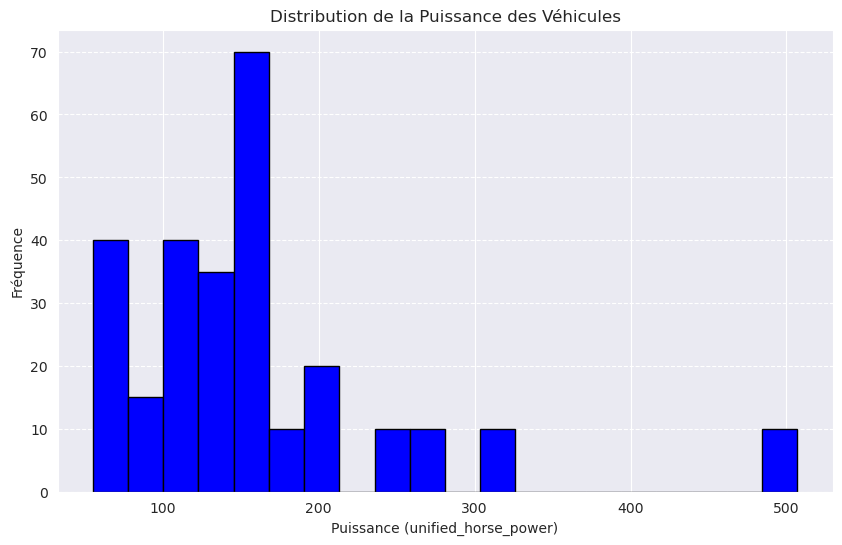

In [9]:
# Extraire les valeurs de la colonne 'unified_horse_power' pour une visualisation avec Matplotlib
horsepower_data = catalogue_df.select("unified_horse_power").rdd.flatMap(lambda x: x).collect()

# Visualiser la distribution
plt.figure(figsize=(10, 6))
plt.hist(horsepower_data, bins=20, color='blue', edgecolor='black')
plt.xlabel("Puissance (unified_horse_power)")
plt.ylabel("Fréquence")
plt.title("Distribution de la Puissance des Véhicules")
plt.grid(axis='y', linestyle='--')
plt.show()

# **Répartition des Véhicules par Nombre de Places**

+--------+-----+
|nbplaces|count|
+--------+-----+
|       5|  240|
|       7|   30|
+--------+-----+


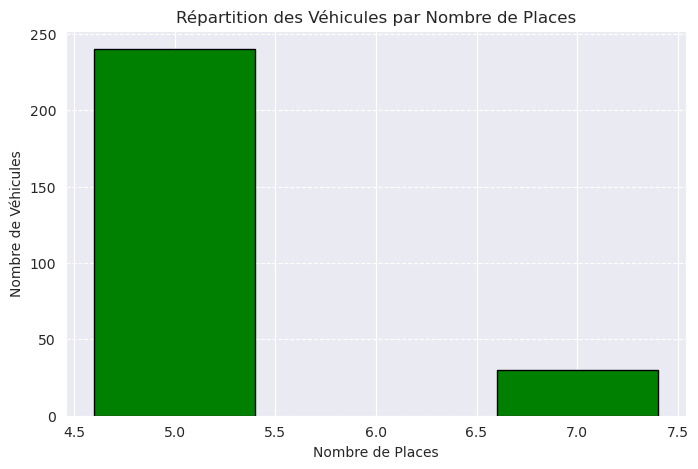

In [10]:
places_df = catalogue_df.groupBy("nbplaces").count()
places_df.show()

# Visualiser la répartition avec Matplotlib
places_data = places_df.rdd.map(lambda row: (row['nbplaces'], row['count'])).collect()
places, counts = zip(*places_data)

plt.figure(figsize=(8, 5))
plt.bar(places, counts, color='green', edgecolor='black')
plt.xlabel("Nombre de Places")
plt.ylabel("Nombre de Véhicules")
plt.title("Répartition des Véhicules par Nombre de Places")
plt.grid(axis='y', linestyle='--')
plt.show()

In [11]:
# **Analyse des Prix des Véhicules (Boxplot par Marque)**

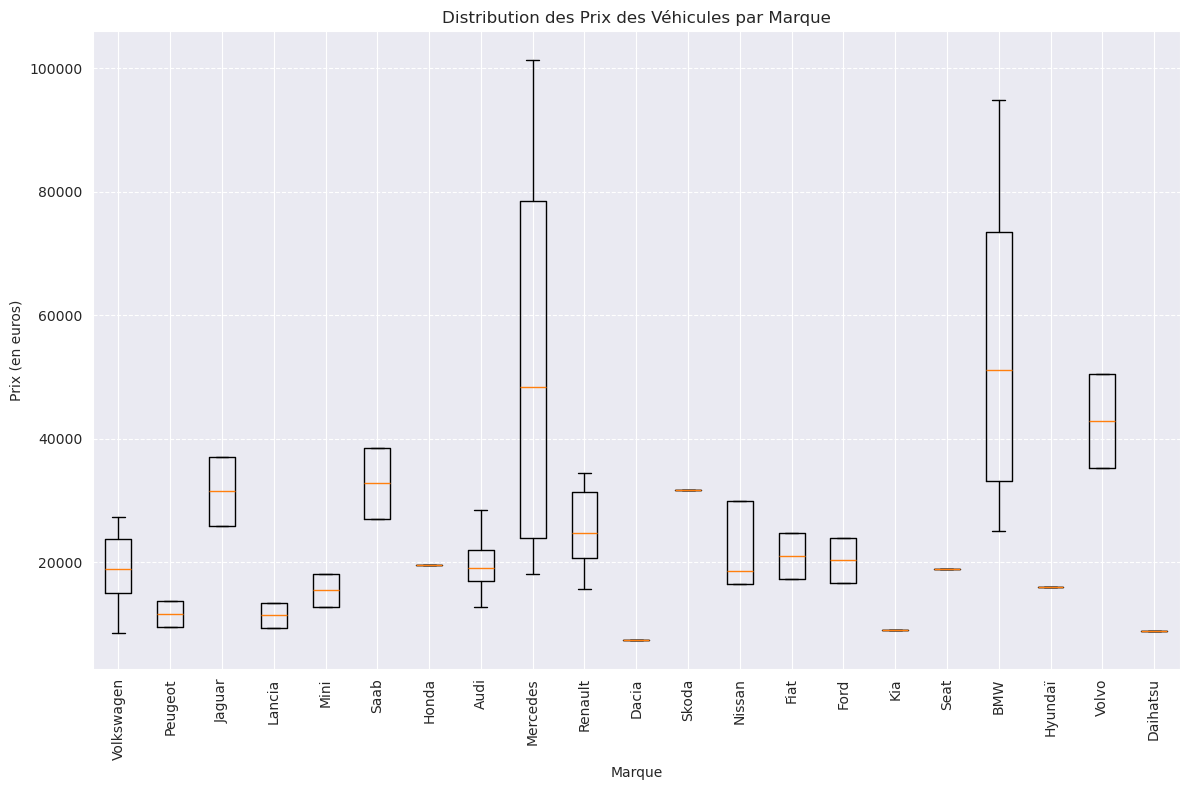

In [12]:
# Préparer les données pour un boxplot
prix_data = catalogue_df.select("marque", "prix").groupBy("marque").agg(F.collect_list("prix").alias("prix_list")).toPandas()

# Visualisation avec Matplotlib
plt.figure(figsize=(12, 8))
plt.boxplot(prix_data['prix_list'], labels=prix_data['marque'], showfliers=False)
plt.xlabel("Marque")
plt.ylabel("Prix (en euros)")
plt.title("Distribution des Prix des Véhicules par Marque")
plt.xticks(rotation=90)
plt.grid(axis='y', linestyle='--')
plt.tight_layout()
plt.show()

# **Relation entre la Puissance et le Prix des Véhicules**


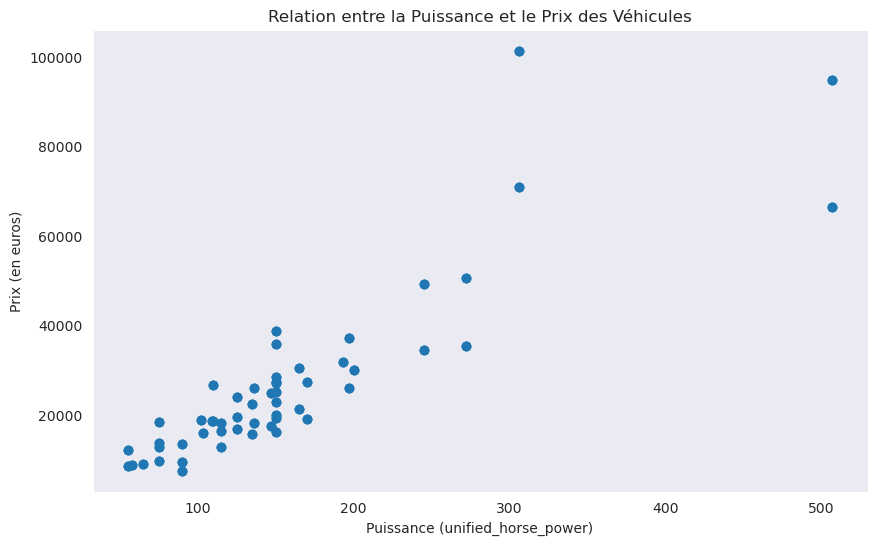

In [13]:
# Extraire les valeurs de 'unified_horse_power' et 'prix'
data = catalogue_df.select("unified_horse_power", "prix").rdd.map(lambda row: (row['unified_horse_power'], row['prix'])).collect()
horsepower, prix = zip(*data)

# Visualiser la relation entre la puissance et le prix
plt.figure(figsize=(10, 6))
plt.scatter(horsepower, prix, alpha=0.6)
plt.xlabel("Puissance (unified_horse_power)")
plt.ylabel("Prix (en euros)")
plt.title("Relation entre la Puissance et le Prix des Véhicules")
plt.grid()
plt.show()

# **Fermer la Session Spark**

In [14]:
# # Arrêter la session Spark
spark.stop()
print("Traitement terminé.")